# Problem Statement
Performing an efficient management of budget and securing accuracy are key points when using crowdsourcing. In classification scenarios the crowd sometimes can be noisy and generate a lack of concensus over tasks. The majority of the state-of-art approaches set a fixed number of votes per item and aggregate the votes with some criteria, this produces a reduction in the quality and an increment of costs. For this reason we present a smart detection algorithm which predicts the best decision between stop or continue collecting votes over a task and analyze its efficiency with different experiments.

Formalizing the problem, given a set of items $I$, a set of votes $V$, a classification function $fn$, a classification threshold $th$ and a cost ratio for crowd to expert vote cost $cr$, for each item we want to find the minimum amount of votes needed to take the decision of continue collecting votes or switch to an expert vote. For this we describe a smart stopping algorithm. 

**We define a 3 methods structure**:
- the **classifier** which returns the probability of an item being classified
- the **cost estimator** which returns the estimated cost for each item given the votes
- the **decision function** which returns a boolean decision for each item

# Rationale for the algorithms

### Classifier function

- Input: item votes
- Output: probability IN [0, 1]

### Cost estimator function


- Input: item votes, classification threshold, classification function, cost ratio
- Output: predicted cost
- Logic:
    - Iterate N times for converging the results
        - Calculate actual cost for the given votes
        - While (is not classified or is not too expensive)
            - If actual cost is not too expensive
                - Get P(IN) using the classification function
                - If P(IN) > threshold or P(OUT) > threshold
                    - **Stop because item is classified**
                - Else
                    - Simulate 1 vote over the item using P(IN)
                    - Increment actual cost
            - Else **stop because the item is too expensive to be classified**

### Decision function



- Input: items, votes, classification_threshold, cost_ratio, classification_function
- Output: Boolean decision over each item, where True = continue and False = stop collecting votes
- Logic:
    - For each item
        - Get P(IN) using the classification function
        - If P(IN) > classification threshold or P(OUT) > classification threshold
            - Decision over item = False
        - Else
            - Call **cost estimator function**
                - If cost estimated <= max cost
                    - Decision over item = True
                - Else
                    - Decision over item = False


### Item Classification without expert vote

* The logic for item classification once votes are collected is defined as:
    * P(i = OUT|item_votes) = 1 - classifier_function(item_votes)
    * If P(i = OUT|item_votes) > classification_threshold -> item is classified as OUT **else** is classified as IN
    
    
    
- This can be interpreted as if there isn't enough evidence(votes) to classify the item OUT, is classified IN. This directly affects the Recall metric due to the false positives.

# Experiments

Here we discuss a few experiments, the objective is to compare the overall crowdsourcing cost and quality in the case where we have a smart stopping algorithm vs 
- the baseline approach where all items receive the same amount of votes
- an approach used by Andrew W. Brown and David B. Allison. 2014. Using Crowdsourcing to Evaluate Published Scientific Literature: Methods and Example. Plos One 9, 7 (2014). Where 2 votes are requested and if they disagree ask a third to break the tie

Also we evaluate the performance using a smart stop detection mechanism in terms of cost and quality for balanced and unbalanced datasets, and in different expert costs.

In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import helpers.algorithms_utils as alg_utils
from IPython.display import HTML
import matplotlib.pyplot as plt
from IPython.core import display as ICD
from helpers.mv_single_binary import majority_voting
from helpers.truth_finder import expectation_maximization
from helpers.truth_finder_single import truth_finder_single
from algorithms.abraham_stop import abraham_stop_binary
from algorithms.smart_stop import decision_function_mv
from algorithms.smart_stop import decision_function_em
import multiprocessing

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Hyperparameters for all experiments

 - Classification function: MV, EM
 - Cost Ratio: [0,1]
 - Workers: 
     - Amount: at least (1/cost_ratio) * increment_parameter
     - Percentage of cheaters: [0,1]
     - Distribution: [0,1]
     - Fixed accuracy for all workers: Boolean
 - Data:
     - Amount: > 0
     - Ground Truth Balance(percentage of positive items): [0,1]
 - Experiment convergence:
     - Amount of iterations: > 0
 - Classification:
     - Thresholds: [0,1]
 - Metrics:
     - Loss ratio(penalty for False Negatives): > 0 
 

In [2]:
#main
'''
cf = majority_voting
cr = .05
base_votes_per_item = 3

#cost estimator
drawing_simulations_amount = 50
expert_cost_increment = 2

#crowd
workers_num = 2000 #fixed number
z = 0 #% cheaters
base_workers_acc = .5
fixed_acc = False
fixed_workers_acc = .9


#ground truth 
items_num = 1000
data_true_percentage = .5

#experiment 
iterations_per_ct = 50
cts = [.5, .6, .7, .8, .9] #classification thresholds

#loss ratio: false negative increment penalization
lr = 5 #1 means not penalization
'''
#alg_utils.print_hyperparameters(cf, cr, base_votes_per_item, drawing_simulations_amount, expert_cost_increment, workers_num, z, fixed_acc, base_workers_acc, fixed_workers_acc, items_num, data_true_percentage, iterations_per_ct, cts, lr)

pdColumns = ["loss_ratio", "cost_ratio", "class_fn", "decision_fn", "data_bal", "threshold", "cost","cost_std", "loss", "loss_std", "recall", "recall_std", "precision", "precision_std"]

## Datasets

### Single-predicate classification
   - **RTE**: 800 items. 
     - Includes binary judgments for textual entailment. 
   - **TEMP**: 462 items. 
     - Includes binary judgments for temporal ordering (i.e., whether one event follows another).
   - **BM**: 1000 items. 
     - (Mozafari et al. 2012) contains negative/positive sentiment labels assigned by AMT workers to tweets.
   - **SpamCF**: 100 items. 
     - (Ipeirotis 2010) includes binary AMT judgments about whether or not an AMT HIT should be considered a “spam” task, according to their criteria.
   - **HCB**: 3275 items. 
     - Conflates relevant classes toproduce only binary labels (Jung and Lease 2011; 2012). 
   - **WVSCM**: 159 items. 
     - (Whitehill et al. 2009) includes AMT binary judgments distinguishing whether or not face images smile.

### Multi-predicate classification
   - **ohsumed-based screening dataset**: 34k Two-predicate screening datasets presented by medical abstracts on different disease categories. 
   - **loneliness-slr-2018**: The dataset includes 585 abstracts of papers annotated by an expert for 2 predicates. The papers are from social informatics domain and used as a part of the systematic literature review (SLR). 
   - **amazon-sentiment-dataset**: 1k-100k dataset on Amazon product reviews, where predicats are 1) Product category 2) Sentiment of the review.
     

In [3]:
datasets = [
    {'folder':'amazon-sentiment-dataset', 'filename':'1k_amazon_reviews_crowdsourced_lemmatized_min3votes.csv','predicates': ['is_negative', 'is_book']},
    {'folder':'loneliness-dataset-2018', 'filename':'loneliness-dataset-2018.csv','predicates': ['oa_predicate', 'study_predicate']},
    {'folder':'ohsumed_data', 'filename':'ohsumed_C14_C23_1grams.csv','predicates': ['C14', 'C23']},
    {'folder':'BarzanMozafari', 'filename':'ground_truth_normalized.csv','predicates':['gt']},
    {'folder':'HyunCatherines_Binary', 'filename':'ground_truth_normalized.csv','predicates':['gt']},  
    {'folder':'RTE', 'filename':'ground_truth_normalized.csv','predicates':['gt']},
    {'folder':'SpamCF', 'filename':'ground_truth_normalized.csv','predicates':['gt']},
    {'folder':'TEMP', 'filename':'ground_truth_normalized.csv','predicates':['gt']}, 
    {'folder':'WVSCM', 'filename':'ground_truth_normalized.csv','predicates':['gt']},
]

In [4]:
def run_experiment(generate_votes_fn, pool):
    main_results = []
    
    
    
    iterables = []
    for ct in cts:
        multi = 5
        for _ in range(multi):
            iterables.append((10, ct, generate_votes_fn))
        
        
        results = pool.map(iterate_ct, iterables)
        
        main_results.append([lr,
                             cr,
                             str(cf.__name__),
                             str(df.__name__),
                             data_true_percentage,
                             ct, 
                             round(np.mean([x[6] for x in results]), 3), 
                             round(np.mean([x[7] for x in results]), 3),
                             round(np.mean([x[8] for x in results]), 3),
                             round(np.mean([x[9] for x in results]), 3),
                             round(np.mean([x[10] for x in results]), 3),
                             round(np.mean([x[11] for x in results]), 3),
                             round(np.mean([x[12] for x in results]), 3),
                             round(np.mean([x[13] for x in results]), 3)])       
        
    
    return main_results


In [4]:
def iterate_ct(triple):
        iterations, ct, generate_votes_fn = triple
        ct = round(ct, 2) #limit to two decimals
        crowd_cost = []
        total_cost = []
        items_classified_in = []
        items_classified_out = []
        ct_loss = []
        ct_recall = []
        ct_precision = []
        ct_classified_amount = []
        ct_unclassified_amount = []
        
        for _ in range(iterations):
            workers_accuracy = alg_utils.simulate_workers(workers_num, z, fixed_acc, fixed_workers_acc, base_workers_acc)
            
            params = {
                'workers_accuracy': workers_accuracy,
                'workers_num': workers_num,
                'items_num': items_num,
                'cost_ratio': cr,
                'votes_per_item': base_votes_per_item,
                'classification_fn': cf
            }
    
            ct_i_results = generate_votes_fn(params, items_num, ct, ground_truth)

            items_classification = ct_i_results[0]
            total_votes = ct_i_results[1]
            
            classified_amount, unclassified_amount, ct_i_crowd_cost, ct_i_total_cost = alg_utils.get_total_cost(total_votes, cr, cf, ct, False)
            
            ct_classified_amount.append(classified_amount)
            ct_unclassified_amount.append(unclassified_amount)
            crowd_cost.append(ct_i_crowd_cost)
            total_cost.append(ct_i_total_cost)

            loss,  recall, precision = alg_utils.Metrics.compute_metrics(items_classification, ground_truth, lr)
            ct_loss.append(loss)
            ct_recall.append(recall)
            ct_precision.append(precision)
        #end for iterations

        return [lr,
             cr,
             str(cf.__name__),
             str(df.__name__),
             data_true_percentage,
             ct, 
             round(np.mean(crowd_cost), 3), 
             round(np.std(crowd_cost), 3),
             round(np.mean(ct_loss), 3),
             round(np.std(ct_loss), 3),
             round(np.mean(ct_recall), 3),
             round(np.std(ct_recall), 3),
             round(np.mean(ct_precision), 3),
             round(np.std(ct_precision), 3)
            ]

## 1) Experiments without considering workers accuracy for predictions

## 1.1) Smart stop with MV as classification function, where the Expected cost is limited by expert cost.

## 1.1.1) Logic

1. Evalute for each classification threshold
2. Iterate N times per threshold for converging results doing:
    1. Generate workers accuracy
    2. Generate ground truth values
    3. Generate the base votes for each item
    4. Call the decision function
        1. If we have any item to continue collecting votes:
            1. Collect 1 more vote per item
            2. Call decision function
    5. Classify items using MV
        1. If P(OUT) > threshold, classify it as OUT
        2. Else classify it as IN
    6. Calculate the metrics

In [5]:
def generate_votes_smart_stop(params, items_num, ct, gt):
    total_votes = {}
    
    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(params['votes_per_item']):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]
            
    #evaluate votes
    results = decision_function(items_num, total_votes, ct, params['cost_ratio'], 
                                                   params['classification_fn'])
    
    #Check if must continue collecting votes
    items_predicted_classified = alg_utils.get_items_predicted_classified(results)
    must_get_more_votes = len(items_predicted_classified) > 0
     
    while(must_get_more_votes):
        total_votes_aux = {}
        for i, v in items_predicted_classified.items():           
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)
            
            total_votes[i][worker_id] = [vote]
            
            total_votes_aux[i] = total_votes[i]
        #end for
        
        results = decision_function(len(total_votes_aux), total_votes_aux, ct, params['cost_ratio'], 
                                                   params['classification_fn'])

        #Stop when there are no more items that can be classified
        items_predicted_classified = alg_utils.get_items_predicted_classified(results)
        must_get_more_votes = len(items_predicted_classified) > 0
    #end while
    
    items_classification = alg_utils.classify_items_mv(total_votes, gt, params['classification_fn'], ct)

    return [items_classification, total_votes]

## 1.2) MV with fixed number of votes per item

In this experiment we use the baseline approach of majority voting with a fixed number of votes per item and a classification threshold of .5

## 1.2.1) Logic

1. Iterate N times for converging results where:
    1. Generate workers accuracy
    2. Generate ground truth values
    3. Generate a fixed number of votes for each item
    4. Classify items using MV
    5. Calculate the metrics

In [5]:
def generate_votes_mv_base(params, items_num, ct, gt):
    total_votes = {}

    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(params['votes_per_item']):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]

    items_classification = alg_utils.classify_items_mv(total_votes, gt, params['classification_fn'], ct)
    
    return [items_classification, total_votes]

## 1.3) Two votes first and if disagree one more to break the tie

In this experiment we collect 2 votes per item and a third one if they disagree.

## 1.3.1) Logic

1. Iterate N times for converging results where:
    1. Generate workers accuracy
    2. Generate ground truth values
    3. Generate 2 votes for each item
    4. Evalutes the votes:
        1. If votes agree:
            1. Jump to next step
        2. If votes disagree:
            1. Get 1 more vote 
    4. Classify items using MV
    5. Calculate the metrics

In [6]:
def generate_votes_break_tie(params, items_num, ct, gt):
    total_votes = {}

    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(2):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]
            
        #if disagree get 1 more vote
        votes_disagree = sum([v[0] for i,v in total_votes[i].items()]) == 1
        if(votes_disagree):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]

    items_classification = alg_utils.classify_items_mv(total_votes, gt, params['classification_fn'], ct)
    
    return [items_classification, total_votes]

# 3.3) Results evaluation

## Experiments with simulated balanced data

##  Analysis over different classification thresholds using different expert costs

### Smart stop over different expert costs

The expert cost has a direct impact in the experiments overall cost, in particular for our approach the expert cost sets a limit for the amount of drawings we do for simulate votes. A lower expert cost means a lower cost ratio between crowd to expert cost, and this is translated in the amount of crowd votes we can collect until reaching the expert.  This is one of the key points in our analysis and this is to choose the best alternative between collecting more votes or not to be more confident for taking a decision for classifying an item. 


To observe how the expert cost impact in the performance we set different costs: 10, 50, 100 and 500. To clarify the notion this can be read easily as a relation, if our expert cost is 10 and the crowd cost is 1 we have to collect 10 crowd votes to reach the expert cost, and can be seen as a ratio 1:10.

to-do clarify:
Expert cost -> # crowd votes -> prob -> classification threshold


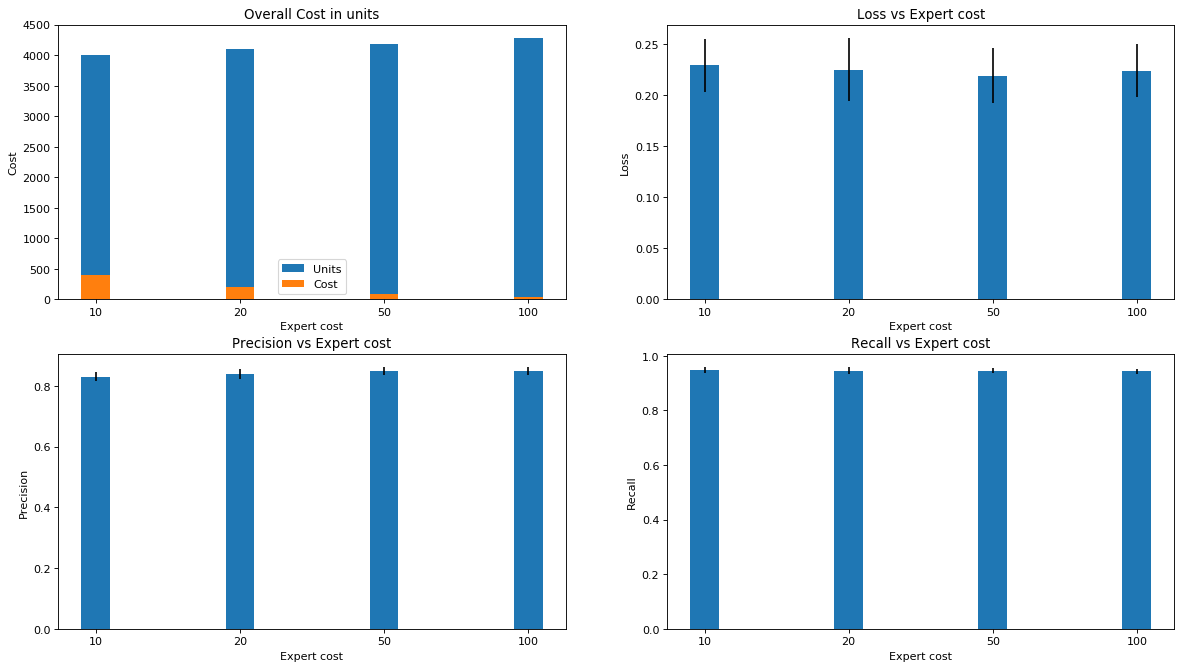

In [54]:
datasets = [
    pd.read_csv('./results/mv/simulated/it50_d50_b5_lr5/smart_stop_mv_not_expert_it50_d50_b5_cr1.csv'),
    pd.read_csv('./results/mv/simulated/it50_d50_b5_lr5/smart_stop_mv_not_expert_it50_d50_b5_cr05.csv'),
    pd.read_csv('./results/mv/simulated/it50_d50_b5_lr5/smart_stop_mv_not_expert_it50_d50_b5_cr02.csv'),
    pd.read_csv('./results/mv/simulated/it50_d50_b5_lr5/smart_stop_mv_not_expert_it50_d50_b5_cr01.csv'),
]

ind = [25,50,75,100]
loss_mean = []
loss_std = []
cost_mean = []
cost_mean_units = []
cost_std = []
precision_mean = []
precision_std = []
recall_mean = []
recall_std = []
costs = [10,20,50,100]
i = 0
for _ in range(len(datasets)):
    cost_mean.append(datasets[i]["Cost mean"][2])
    cost_mean_units.append(datasets[i]["Cost mean"][2] * costs[i])
    cost_std.append(datasets[i]["Cost Std"][2])
    loss_mean.append(datasets[i]["Loss mean"][2])
    loss_std.append(datasets[i]["Loss Std"][2])
    precision_mean.append(datasets[i]["Precision mean"][2])
    precision_std.append(datasets[i]["Precision Std"][2])
    recall_mean.append(datasets[i]["Recall mean"][2])
    recall_std.append(datasets[i]["Recall Std"][2])
    
    i += 1


plt.figure(num=1, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
ind = [.25, .5, .75, 1]    # the x locations for the groups
width = 0.05       # the width of the bars: can also be len(x) sequence

plt.subplot(221)

p1 = plt.bar(ind, cost_mean_units, width, yerr=cost_std)
p2 = plt.bar(ind, cost_mean, width, yerr=cost_std)
plt.ylabel('Cost')
plt.xlabel('Expert cost')
plt.title('Overall Cost in units')
plt.xticks(ind, ('10', '20', '50', '100'))
plt.legend((p1[0], p2[0]), ('Units', 'Cost'))


plt.subplot(222)
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Loss')
plt.xlabel('Expert cost')
plt.title('Loss vs Expert cost')
plt.xticks(ind, ('10', '20', '50', '100'))

plt.subplot(223)
p2 = plt.bar(ind, precision_mean, width, yerr=precision_std)
plt.ylabel('Precision')
plt.xlabel('Expert cost')
plt.title('Precision vs Expert cost')
plt.xticks(ind, ('10', '20', '50', '100'))

plt.subplot(224)
p2 = plt.bar(ind, recall_mean, width, yerr=recall_std)
plt.ylabel('Recall')
plt.xlabel('Expert cost')
plt.title('Recall vs Expert cost')
plt.xticks(ind, ('10', '20', '50', '100'))

plt.show()

**SmartStop approach behaviour using MV. Simulations for balanced data, over different classifications threshold = .7, with 1000 balanced items, expert costs 10, 20, 50 and 100, workers acc mean ≈ 76%, loss ratio = 5.**

In the graphics we can observe that the cost ratio don't affect the quality. This was expected given the prior analysis of the behaviour of majority voting, when having collected 3 votes which only 2 agree MV gives us a 66,6 probability of being classified as one class, and if we collect 1 more this can turn this probability in 75% if agree and gets classified, or 50% if disagree turning it in what we assume the worse case for drawing because represent random voting.

### Smart stop over different classification thresholds with fixed expert cost

One point to see is the performance of the approach using the smart stop mechanism over different classification thresholds with a fixed expert cost, with this we expect to see the behaviour between the classification function, the threshold and the given cost.

SmartStop


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.000,0.000,0.471,0.050,0.843,0.019,0.842,0.014
1,0.6,150.000,0.000,0.472,0.042,0.842,0.016,0.847,0.013
2,0.7,205.180,2.322,0.225,0.031,0.946,0.012,0.840,0.016
3,0.8,187.088,1.816,0.271,0.021,0.984,0.007,0.680,0.013
4,0.9,150.000,0.000,0.327,0.020,0.985,0.006,0.631,0.009


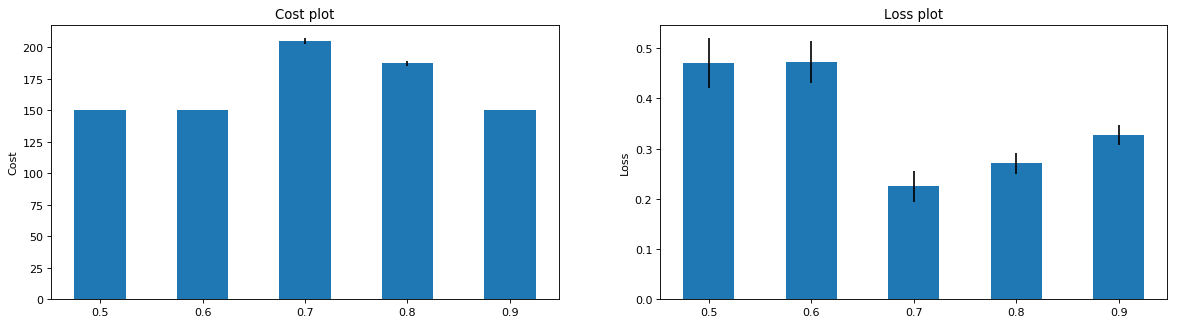

In [50]:
smv_05 = pd.read_csv('./results/mv/simulated/it50_d50_b5_lr5/smart_stop_mv_not_expert_it50_d50_b5_cr05.csv')

print_table_columns = ["Threshold", "Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]

print("SmartStop")
ICD.display(pd.DataFrame(smv_05, columns=print_table_columns))


plt.figure(num=2, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
ind = [.5,.6,.7,.8,.9]    # the x locations for the groups
width = 0.05       # the width of the bars: can also be len(x) sequence

cost_mean = smv_05["Cost mean"]
cost_std = smv_05["Cost Std"]

plt.subplot(221)

p1 = plt.bar(ind, cost_mean, width, yerr=cost_std)

plt.ylabel('Cost')
plt.title('Cost plot')


plt.subplot(222)
loss_mean = smv_05["Loss mean"]
loss_std = smv_05["Loss Std"]
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Loss')
plt.title('Loss plot')


plt.show()

**SmartStop approach behaviour using MV. Simulations for balanced data, over different classifications threshold = [.5, .6, .7, .8, .9], with 1000 balanced items, expert cost 20, workers acc mean ≈ 76%, loss ratio = 5.**

### Cost vs loss

***SmartStop approach performance analysis:***

 - We can observe for the classification thresholds .5 and .6 the same behaviour given the percentage obtained by MV when 3 votes are collected. When the 3 votes collected agree MV gives us a 100% probability of being classified as 1 of the 2 classes, either 0 or 1, instead when only 2 votes agree we get a 66,6% chance of classification over one class and this reachs .5 and .6 thresholds acting as the baseline logic. 

 - For threshold .7 we observe that many votes were collected(**1096** more than base) which incremented the quality reducing the loss(and many false negatives) keeping the same precision of lower threshold but incrementing the recall significantly. Comparing the other values we can conclude that this was the better cost-quality performance. 

 - For threshold .8 we can see that more votes have been collected(**738** more than base) but not as many as in the previous, this can be expected due to the bigger difference between the initial item probability of being classified and the threshold(%66,6->%80). The longer this difference is, the more the number of votes will be needed to reach it, and higher is the chance of error. 

 - For threshold .9 no votes were collected and this can be expectable given the big gap between the initial classification probability and threshold(%66,6->%90). We can do further analysis to see this case... **DISCUSS if is needed!!!!**

### Error Rate: penalizing false negatives

We add a loss ratio to penalyze the false negatives which we consiser to be more harmful than the false positives, because are those items which are loss forever. With this table we expect to see the performance of the approaches over different classification thresholds, with a loss ratio = 5, expert cost = 20, over 1000 balanced data, 3 initial votes for MV and SMV.

We set a loss ratio in 5 as we think is a conservative value.

<!---
| Approach      | Threshold | Cost   | Error rate | Error rate lr=10 | Precision | Recall |
|---------------|-----------|--------|------------|------------------|-----------|--------|
| Baseline MV   | .5        | 3000   | 0.156      | 0.874            | 0.845     | 0.842  |
| Brown&Allison | .5        | 2377,44| 0.115      | 0.859            | 0.841     | 0.849  |
| SmartStop MV  | .5        | 3000   | 0.158      | 0.855            | 0.843     | 0.841  |
| SmartStop MV  | .6        | 3000   | 0.157      | 0.852            | 0.843     | 0.843  |
| SmartStop MV  | .7        | 4096,16| 0.115      | 0.353            | 0.842     | 0.947  |
| SmartStop MV  | .8        | 3738   | 0.241      | 0.321            | 0.679     | 0.983  |
| SmartStop MV  | .9        | 3000   | 0.298      | 0.371            | 0.629     | 0.984  |

-->



In [ ]:
print_table_columns = ["Threshold", "Cost mean","Cost Std", "TC mean", "TC std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]
smv_mix = pd.DataFrame({}, columns=print_table_columns)
smv_mix["Loss lr=5"] = []
smv_mix["Name"] = []

smv_mix.loc[0] = [.5, \
             ba_lr1["Cost mean"][0], ba_lr1["Cost Std"][0], \
             ba_lr1["TC mean"][0], ba_lr1["TC std"][0], \
             ba_lr1["Loss mean"][0], ba_lr1["Loss Std"][0], \
             ba_lr1["Recall mean"][0], ba_lr1["Recall Std"][0],\
             ba_lr1["Precision mean"][0], ba_lr1["Precision Std"][0], \
             ba_lr5["Loss mean"][0], "Brown&Allison"]

smv_mix.loc[1] = [.5, \
             mv_base_lr1["Cost mean"][0], mv_base_lr1["Cost Std"][0], \
             mv_base_lr1["TC mean"][0], mv_base_lr1["TC std"][0], \
             mv_base_lr1["Loss mean"][0], mv_base_lr5["Loss Std"][0], \
             mv_base_lr1["Recall mean"][0], mv_base_lr1["Recall Std"][0],\
             mv_base_lr1["Precision mean"][0], mv_base_lr1["Precision Std"][0], \
             mv_base_lr5["Loss mean"][0], "MV Baseline"]

smv_lr1 = pd.read_csv('./results/mv/simulated/it50_d50_b5_lr1/smart_stop_mv_not_expert_it50_d50_b5_cr05.csv')
smv_lr5 = pd.read_csv('./results/mv/simulated/it50_d50_b5_lr5/smart_stop_mv_not_expert_it50_d50_b5_cr05.csv')

idx = 2
for key in range(5):
    smv_mix.loc[idx] = [np.mean([smv_lr1["Threshold"][key], smv_lr5["Threshold"][key]]), \
             np.mean([smv_lr1["Cost mean"][key], smv_lr5["Cost mean"][key]]), \
             np.mean([smv_lr1["Cost Std"][key], smv_lr5["Cost Std"][key]]), \
             np.mean([smv_lr1["TC mean"][key], smv_lr5["TC mean"][key]]), \
             np.mean([smv_lr1["TC std"][key], smv_lr5["TC std"][key]]), \
             smv_lr1["Loss mean"][key], \
             np.mean([smv_lr1["Loss Std"][key], smv_lr5["Loss Std"][key]]), \
             np.mean([smv_lr1["Recall mean"][key], smv_lr5["Recall mean"][key]]), \
             np.mean([smv_lr1["Recall Std"][key], smv_lr5["Recall Std"][key]]),\
             np.mean([smv_lr1["Precision mean"][key], smv_lr5["Precision mean"][key]]), \
             np.mean([smv_lr1["Precision Std"][key], smv_lr5["Precision Std"][key]]), \
             smv_lr5["Loss mean"][key], \
                        "SmartStop MV"]
    
    idx += 1


df = pd.DataFrame(smv_mix, columns=["Name", "Threshold", "Loss mean", "Loss lr=5"])
df.columns = ["Name", "Threshold", "Error rate lr=1", "Error rate lr=5"]
df

### Performance comparison with other approaches

In this case we compare the cost and quality results against the other approaches, we can expect to see an improvement in quality at a reasonable cost when the smart stop module predict to collect more votes. Given the conservative classification criteria, which is to collect votes to ***exclude*** items and if there is not enough evidence ***include*** them, affects the **precision** because the increment in **false positives(FP)**, following a binary classification terminology we can describe them as those items which real value is ***0*** and are classified as ***1***.

MV Baseline


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.0,0.0,0.472,0.045,0.843,0.017,0.843,0.017


Brown&Allison 2-1 Break Tie


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,118.713,0.736,0.454,0.04,0.849,0.016,0.848,0.015


SmartStop cf=MV


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.000,0.000,0.471,0.050,0.843,0.019,0.842,0.014
1,0.6,150.000,0.000,0.472,0.042,0.842,0.016,0.847,0.013
2,0.7,205.180,2.322,0.225,0.031,0.946,0.012,0.840,0.016
3,0.8,187.088,1.816,0.271,0.021,0.984,0.007,0.680,0.013
4,0.9,150.000,0.000,0.327,0.020,0.985,0.006,0.631,0.009


SmartStop cf=EM-TruthFinder


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.0,0.0,0.480,0.037,0.840,0.014,0.840,0.013
1,0.6,150.0,0.0,0.472,0.034,0.843,0.014,0.842,0.016
2,0.7,150.0,0.0,0.466,0.045,0.846,0.018,0.841,0.013
3,0.8,150.0,0.0,0.468,0.042,0.844,0.016,0.844,0.014
4,0.9,150.0,0.0,0.468,0.045,0.844,0.017,0.843,0.012


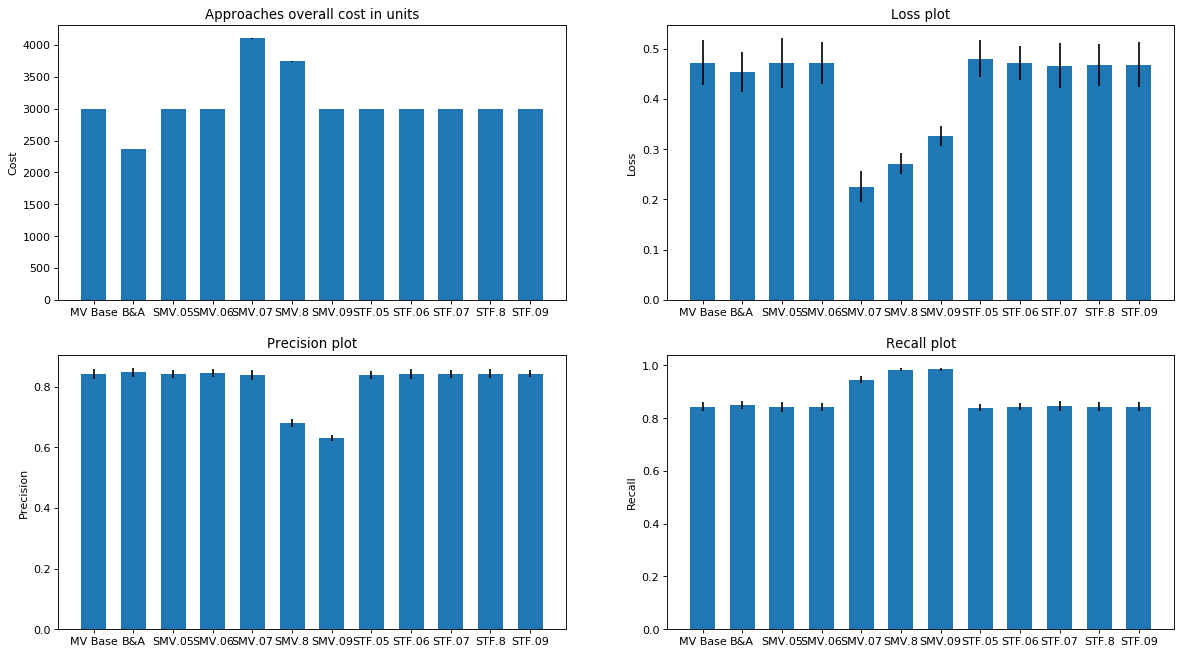

In [26]:
from IPython.core import display as ICD

mv_base_01 = pd.read_csv('./results/mv/simulated/it50_d50_b5_lr5/baseline_mv_it50_b5_v3_cr05.csv')
ba_01 = pd.read_csv('./results/mv/simulated/it50_d50_b5_lr5/mv_break_tie_it50_b5_cr05.csv')
smv_01 = pd.read_csv('./results/mv/simulated/it50_d50_b5_lr5/smart_stop_mv_not_expert_it50_d50_b5_cr05.csv')
sem_05 = pd.read_csv('./results/tf/simulated/it50_d10_b5_lr5_cr05/results_b5_lr5_cr05.csv')

print_table_columns = ["Threshold", "Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]

print("MV Baseline")
ICD.display(pd.DataFrame(mv_base_01, columns=print_table_columns))

print("Brown&Allison 2-1 Break Tie")
ICD.display(pd.DataFrame(ba_01, columns=print_table_columns))

print("SmartStop cf=MV")
ICD.display(pd.DataFrame(smv_01, columns=print_table_columns))

print("SmartStop cf=EM-TruthFinder")
ICD.display(pd.DataFrame(sem_05, columns=print_table_columns))

#plot
datasets_print = [mv_base_01, ba_01, smv_01, sem_05]

def get_approaches_results(datasets, column_mean, column_std):
    mean = []
    std = []
    #initial
    mean.append(datasets[0][column_mean][0])
    std.append(datasets[0][column_std][0])
    mean.append(datasets[1][column_mean][0])
    std.append(datasets[1][column_std][0])

    i = 0
    for _ in range(5):
        mean.append(datasets[2][column_mean][i])
        std.append(datasets[2][column_std][i])
        
        i += 1
    i = 0
    for _ in range(5):
        mean.append(datasets[3][column_mean][i])
        std.append(datasets[3][column_std][i])
        
        i += 1
        
    return mean, std

plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
#ind = [.14, .28, .42, .56, .70 , .84, 1]    # the x locations for the groups
ind = [0.08, 0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 , 0.88,
        0.96]
width = 0.05

cost_mean, cost_std = get_approaches_results(datasets_print, "Cost mean", "Cost Std")

plt.subplot(221)

p1 = plt.bar(ind, [x * 20 for x in cost_mean], width, yerr=cost_std)

plt.ylabel('Cost')
plt.title('Approaches overall cost in units')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09', 'STF.05', 'STF.06', 'STF.07', 'STF.8', 'STF.09'))


plt.subplot(222)
loss_mean, loss_std = get_approaches_results(datasets_print, "Loss mean", "Loss Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Loss')
plt.title('Loss plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09', 'STF.05', 'STF.06', 'STF.07', 'STF.8', 'STF.09'))


plt.subplot(223)
loss_mean, loss_std = get_approaches_results(datasets_print, "Precision mean", "Precision Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Precision')
plt.title('Precision plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09', 'STF.05', 'STF.06', 'STF.07', 'STF.8', 'STF.09'))


plt.subplot(224)
loss_mean, loss_std = get_approaches_results(datasets_print, "Recall mean", "Recall Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Recall')
plt.title('Recall plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09', 'STF.05', 'STF.06', 'STF.07', 'STF.8', 'STF.09'))

plt.show()


**Behaviour of the approaches. Simulations for unbalanced data 10% possitives, smart stop evaluated over different classifications threshold = [.5, .6, .7, .8, .9], with 1000 balanced items, expert cost 20, workers acc mean ≈ 76%, loss ratio = 5.**

As expected the quality was higher when using the module predictions, reducing the loss and incrementing the recall, as an effect of the classification criteria the precision is reduced. In the case of threshold .9 the recall is high because it reduces the false negative amount due to it strictness, but it has a big impact in precision becoming this case the worse one in terms of number of false positives.

## 3.3.2) Experiments with unbalanced data

At this point we are interested in analyzing the cost-quality performance of the approaches over unbalanced data.

In [ ]:
iterations_per_ct = 50
drawing_simulations_amount = 50
data_true_percentage = .5
b_str = str(round(data_true_percentage-int(data_true_percentage), 2))[2:]
lr = 5
folder_name = f'it{iterations_per_ct}_d{drawing_simulations_amount}_b{b_str}_lr{lr}'

#crs = [1/10, 1/50, 1/100, 1/500] # .1, .02, .01, .002
crs = [1/500]

ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)

for cr in crs:
    cts = [.5, .6, .7 , .8 , .9]
     
    cr = round(cr,3)
    cr_str = str(round(cr-int(cr), 2))[2:]  
    
    #SMV
    results_smv = run_experiment(generate_votes_smart_stop)
    pd.DataFrame(results_smv, columns=pdColumns) \
    .to_csv(f'results/mv/{folder_name}/smart_stop_mv_not_expert_it{iterations_per_ct}_d{drawing_simulations_amount}_b{b_str}_cr{cr_str}.csv', index=False)

'''
cts = [.5]

#mv baseline
results_baseline = run_experiment_2()
pd.DataFrame(results_baseline, columns=pdColumns) \
    .to_csv(f'results/mv/{folder_name}/baseline_mv_it{iterations_per_ct}_b{b_str}_v{base_votes_per_item}_cr{cr_str}.csv', index=False)

#break tie
results_b_a = run_experiment_3()
pd.DataFrame(results_b_a, columns=pdColumns) \
    .to_csv(f'results/mv/{folder_name}/mv_break_tie_it{iterations_per_ct}_b{b_str}_cr{cr_str}.csv', index=False)
'''
    

### Results for unbalanced data 10% positives - 90% negatives

MV Baseline


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.0,0.0,0.22,0.023,0.841,0.036,0.375,0.024


Brown&Allison 2-1 Break Tie


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,118.69,0.85,0.222,0.023,0.837,0.038,0.374,0.023


SmartStop


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.000,0.000,0.219,0.019,0.844,0.032,0.375,0.021
1,0.6,150.000,0.000,0.220,0.022,0.839,0.036,0.376,0.021
2,0.7,205.078,2.647,0.183,0.016,0.950,0.023,0.376,0.018
3,0.8,186.793,1.526,0.427,0.020,0.985,0.012,0.190,0.007
4,0.9,150.000,0.000,0.530,0.016,0.982,0.013,0.159,0.004


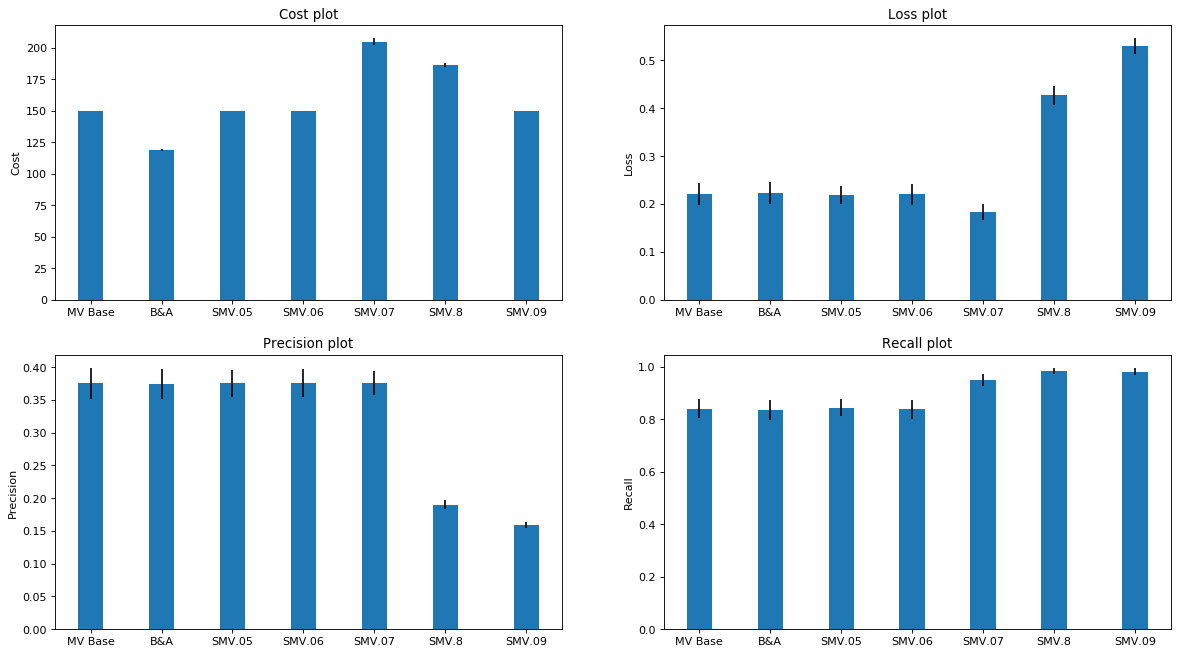

In [125]:
from IPython.core import display as ICD

mv_base_01 = pd.read_csv('./results/mv/simulated/it50_d50_b1_lr5/baseline_mv_it50_b1_v3_cr05.csv')
ba_01 = pd.read_csv('./results/mv/simulated/it50_d50_b1_lr5/mv_break_tie_it50_b1_cr05.csv')
smv_01 = pd.read_csv('./results/mv/simulated/it50_d50_b1_lr5/smart_stop_mv_not_expert_it50_d50_b1_cr05.csv')

print_table_columns = ["Threshold", "Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]

print("MV Baseline")
ICD.display(pd.DataFrame(mv_base_01, columns=print_table_columns))

print("Brown&Allison 2-1 Break Tie")
ICD.display(pd.DataFrame(ba_01, columns=print_table_columns))

print("SmartStop")
ICD.display(pd.DataFrame(smv_01, columns=print_table_columns))

#plot
datasets = [mv_base_01, ba_01, smv_01]

def get_approaches_results(datasets, column_mean, column_std):
    mean = []
    std = []
    #initial
    mean.append(datasets[0][column_mean][0])
    std.append(datasets[0][column_std][0])
    mean.append(datasets[1][column_mean][0])
    std.append(datasets[1][column_std][0])

    i = 0
    for _ in range(5):
        mean.append(datasets[2][column_mean][i])
        std.append(datasets[2][column_std][i])
        i += 1
        
    return mean, std

plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
ind = [.14, .28, .42, .56, .70 , .84, 1]    # the x locations for the groups
width = 0.05       # the width of the bars: can also be len(x) sequence

cost_mean, cost_std = get_approaches_results(datasets, "Cost mean", "Cost Std")

plt.subplot(221)

p1 = plt.bar(ind, cost_mean, width, yerr=cost_std)

plt.ylabel('Cost')
plt.title('Cost plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(222)
loss_mean, loss_std = get_approaches_results(datasets, "Loss mean", "Loss Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Loss')
plt.title('Loss plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(223)
loss_mean, loss_std = get_approaches_results(datasets, "Precision mean", "Precision Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Precision')
plt.title('Precision plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(224)
loss_mean, loss_std = get_approaches_results(datasets, "Recall mean", "Recall Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Recall')
plt.title('Recall plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.show()


**Behaviour of the approaches. Simulations for unbalanced data 10% possitives, over different classifications threshold = [.5, .6, .7, .8, .9], with 1000 balanced items, expert cost 20, workers acc mean ≈ 76%, loss ratio = 5.**

We can get similar conclusion with unbalanced data, the threshold .7 continue having the better performance in terms of cost-quality. In particular the bigger thresholds(.8 and .9) are affected significantly in this case compared to balanced dataset, again the reason is the impact of false positives that in this case are more likely to appear.

### 3.3.3) Results for unbalanced data 1% positives - 99% negatives

MV Baseline


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.0,0.0,0.161,0.013,0.85,0.115,0.053,0.008


Brown&Allison 2-1 Break Tie


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,118.697,0.766,0.164,0.013,0.852,0.102,0.052,0.007


SmartStop


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.000,0.000,0.162,0.013,0.862,0.120,0.053,0.008
1,0.6,150.000,0.000,0.166,0.017,0.844,0.134,0.051,0.010
2,0.7,204.914,2.273,0.177,0.013,0.958,0.064,0.052,0.005
3,0.8,187.348,1.610,0.463,0.018,0.970,0.050,0.021,0.001
4,0.9,150.000,0.000,0.575,0.015,0.980,0.040,0.017,0.001


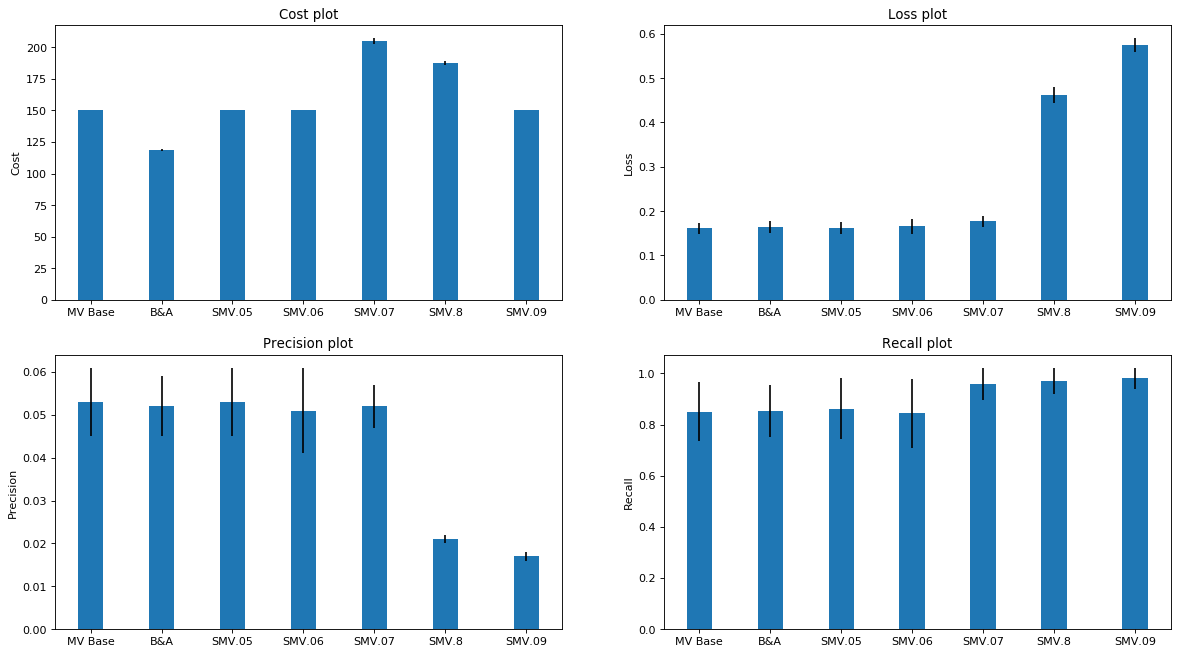

In [126]:
from IPython.core import display as ICD

mv_base_01 = pd.read_csv('./results/mv/simulated/it50_d50_b01_lr5/baseline_mv_it50_b01_v3_cr05.csv')
ba_01 = pd.read_csv('./results/mv/simulated/it50_d50_b01_lr5/mv_break_tie_it50_b01_cr05.csv')
smv_01 = pd.read_csv('./results/mv/simulated/it50_d50_b01_lr5/smart_stop_mv_not_expert_it50_d50_b01_cr05.csv')

print_table_columns = ["Threshold", "Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]

print("MV Baseline")
ICD.display(pd.DataFrame(mv_base_01, columns=print_table_columns))

print("Brown&Allison 2-1 Break Tie")
ICD.display(pd.DataFrame(ba_01, columns=print_table_columns))

print("SmartStop")
ICD.display(pd.DataFrame(smv_01, columns=print_table_columns))

#plot
datasets = [mv_base_01, ba_01, smv_01]

def get_approaches_results(datasets, column_mean, column_std):
    mean = []
    std = []
    #initial
    mean.append(datasets[0][column_mean][0])
    std.append(datasets[0][column_std][0])
    mean.append(datasets[1][column_mean][0])
    std.append(datasets[1][column_std][0])

    i = 0
    for _ in range(5):
        mean.append(datasets[2][column_mean][i])
        std.append(datasets[2][column_std][i])
        i += 1
        
    return mean, std

plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
ind = [.14, .28, .42, .56, .70 , .84, 1]    # the x locations for the groups
width = 0.05       # the width of the bars: can also be len(x) sequence

cost_mean, cost_std = get_approaches_results(datasets, "Cost mean", "Cost Std")

plt.subplot(221)

p1 = plt.bar(ind, cost_mean, width, yerr=cost_std)

plt.ylabel('Cost')
plt.title('Cost plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(222)
loss_mean, loss_std = get_approaches_results(datasets, "Loss mean", "Loss Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Loss')
plt.title('Loss plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(223)
loss_mean, loss_std = get_approaches_results(datasets, "Precision mean", "Precision Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Precision')
plt.title('Precision plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(224)
loss_mean, loss_std = get_approaches_results(datasets, "Recall mean", "Recall Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Recall')
plt.title('Recall plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))

plt.show()


**Behaviour of the approaches. Simulations for unbalanced data 1% possitives, over different classifications threshold = [.5, .6, .7, .8, .9], with 1000 balanced items, expert cost 20, workers acc mean ≈ 76%, loss ratio = 5.**

This case is similar to the previous one, with the difference of having a bigger difference in precision values of thresholds .8 and .9, and as expected a directly related loss increment.

## Real-world datasets

### Amazon sentiment dataset 1k items unbalanced dataset

In [ ]:
datasets = [
    {'folder':'amazon-sentiment-dataset', 'filename':'1k_amazon_reviews_crowdsourced_lemmatized_min3votes.csv','predicates':['is_book']},
    {'folder':'loneliness-dataset-2018', 'filename':'loneliness-dataset-2018.csv','predicates':['study_predicate']},
    {'folder':'ohsumed_data', 'filename':'ohsumed_C14_C23_1grams.csv','predicates':['C14']},
]

for dataset in datasets:
    #work over 1 predicate
    base_folder = dataset['folder']
    filename = dataset['filename']
    path = f'data/{base_folder}/{filename}'
    X, y_screening, y_predicate = alg_utils.load_data(path, dataset['predicates'])
    ground_truth = y_predicate[dataset['predicates'][0]]
    
    #analyze max 5k items for now
    if (len(ground_truth) > 5000):
        ground_truth = ground_truth[:5000]
    
    items_num = len(ground_truth)

    iterations_per_ct = 50
    drawing_simulations_amount = 10
    lr = 5
    cr = 0.05
    
    cr_str = str(round(cr-int(cr), 2))[2:]
    folder_name = f'mv/{base_folder}/it{iterations_per_ct}_d{drawing_simulations_amount}_lr{lr}'
    

    cts = [.7]

    #SMV
    results_smv = run_experiment_1()
    pd.DataFrame(results_smv, columns=pdColumns) \
    .to_csv(f'results/{folder_name}/smart_stop_mv_not_expert_it{iterations_per_ct}_d{drawing_simulations_amount}_cr{cr_str}.csv', index=False)

    
    cts = [.5]

    #mv baseline
    results_baseline = run_experiment_2()
    print(pd.DataFrame(results_baseline, columns=pdColumns))
        #.to_csv(f'results/{folder_name}/baseline_mv_it{iterations_per_ct}_v{base_votes_per_item}_cr{cr_str}.csv', index=False)


    #break tie
    results_b_a = run_experiment_3()
    pd.DataFrame(results_b_a, columns=pdColumns) \
        .to_csv(f'results/{folder_name}/mv_break_tie_it{iterations_per_ct}_cr{cr_str}.csv', index=False)

    

MV Baseline


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,148.35,0.0,0.538,0.053,0.844,0.017,0.894,0.01


Brown&Allison 2-1 Break Tie


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,117.445,0.656,0.541,0.05,0.843,0.016,0.894,0.012


SmartStop


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.7,202.949,2.403,0.229,0.035,0.948,0.01,0.894,0.014


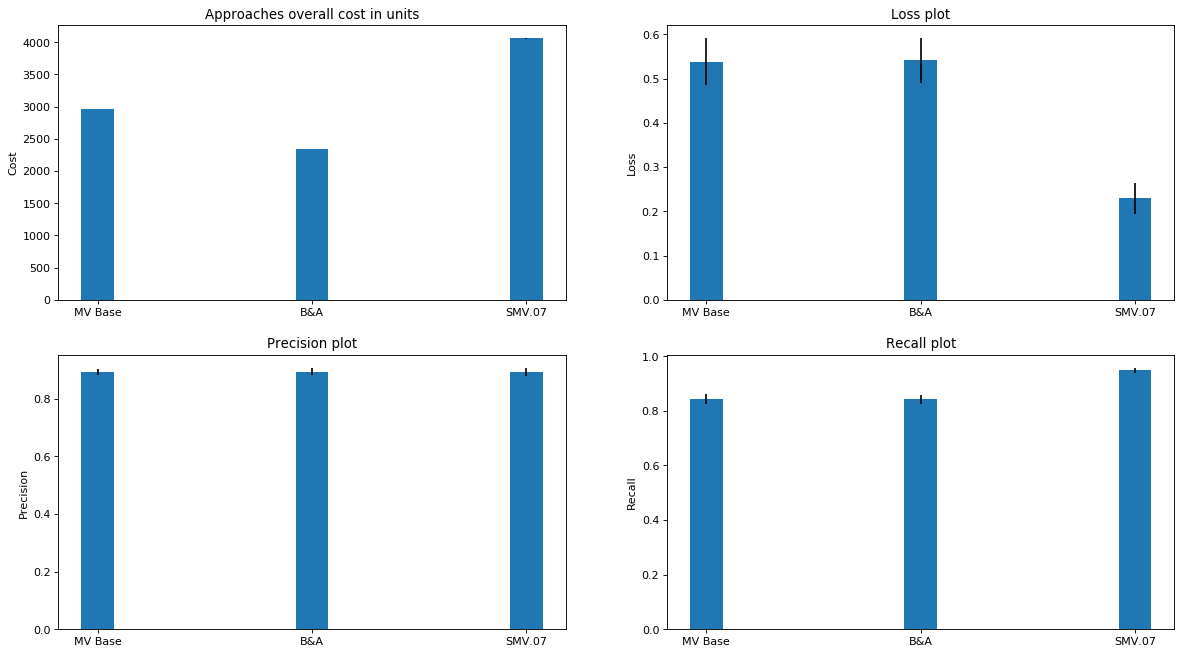

In [22]:
from IPython.core import display as ICD

mv_base_01 = pd.read_csv('./results/mv/amazon-sentiment-dataset/it50_d50_lr5/baseline_mv_it50_v3_cr05.csv')
ba_01 = pd.read_csv('./results/mv/amazon-sentiment-dataset/it50_d50_lr5/mv_break_tie_it50_cr05.csv')
smv_01 = pd.read_csv('./results/mv/amazon-sentiment-dataset/it50_d50_lr5/smart_stop_mv_not_expert_it50_d50_cr05.csv')

print_table_columns = ["Threshold", "Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]

print("MV Baseline")
ICD.display(pd.DataFrame(mv_base_01, columns=print_table_columns))

print("Brown&Allison 2-1 Break Tie")
ICD.display(pd.DataFrame(ba_01, columns=print_table_columns))

print("SmartStop")
ICD.display(pd.DataFrame(smv_01, columns=print_table_columns))

#plot
datasets = [mv_base_01, ba_01, smv_01]

def get_approaches_results(datasets, column_mean, column_std):
    mean = []
    std = []
    #initial
    mean.append(datasets[0][column_mean][0])
    std.append(datasets[0][column_std][0])
    mean.append(datasets[1][column_mean][0])
    std.append(datasets[1][column_std][0])
    mean.append(datasets[2][column_mean][0])
    std.append(datasets[2][column_std][0])
        
    return mean, std

plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
ind = [.33, .66, .99]    # the x locations for the groups
width = 0.05       # the width of the bars: can also be len(x) sequence


plt.subplot(221)
cost_mean, cost_std = get_approaches_results(datasets, "Cost mean", "Cost Std")
p1 = plt.bar(ind, [x * 20 for x in cost_mean], width, yerr=cost_std)
plt.ylabel('Cost')
plt.title('Approaches overall cost in units')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.07'))


plt.subplot(222)
loss_mean, loss_std = get_approaches_results(datasets, "Loss mean", "Loss Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Loss')
plt.title('Loss plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.07'))


plt.subplot(223)
loss_mean, loss_std = get_approaches_results(datasets, "Precision mean", "Precision Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Precision')
plt.title('Precision plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.07'))


plt.subplot(224)
loss_mean, loss_std = get_approaches_results(datasets, "Recall mean", "Recall Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Recall')
plt.title('Recall plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.07'))

plt.show()


**Behaviour of the approaches. Simulations for real-world 1k Amazon sentiment data(unbalanced data), expert cost 20, workers acc mean ≈ 76%, loss ratio = 5.**

## 4) Next step: Experiments estimating workers accuracy, using Expectation Maximization(EM)

In [5]:
#ground truth data
items_num = 1000
base_votes_per_item = 3

#metrics
lr = 5

#workers
workers_num = 2000 #fixed number
z = 0 #% cheaters
base_workers_acc = .5
fixed_acc = False
fixed_workers_acc = .9

#iterables
cts = [.5, .6]#, .7 , .8 , .9]
iterations_per_ct = 50

cost_ratios = [1/10]#, 1/20]#, 1/50, 1/100]
data_true_balances = [.5]#, .3, .1]
classification_fns = [majority_voting]#, truth_finder_single]
decision_fns = [decision_function_em]

total_results = []

print(f'workers: {workers_num}, \n loss ratio: {lr}, \n thresholds: {str(cts)}, \n accuracy: [{str(base_workers_acc)},1], \n iterations per ct: {iterations_per_ct}')

pool = multiprocessing.Pool(processes=5)

for df in decision_fns:
    decision_function = df
    for cf in classification_fns:
        for data_bal in data_true_balances:
            data_true_percentage = data_bal
            ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)
            for cr in cost_ratios:
                print(f'decision fn: {df.__name__}, classification fn: {cf.__name__}, data balance: {data_bal}, cost ratio: {cr}')
                
                combination_results = run_experiment(generate_votes_smart_stop, pool)
                for res_a in combination_results:
                    total_results.append(res_a)
                
                pd.DataFrame(total_results, columns=pdColumns).to_csv(f'results/simulated_dataset/all_combinations_results.csv', index=False)

pool.close()

workers: 2000, 
 loss ratio: 5, 
 thresholds: [0.5, 0.6], 
 accuracy: [0.5,1], 
 iterations per ct: 50
decision fn: decision_function_em, classification fn: majority_voting, data balance: 0.5, cost ratio: 0.1


NameError: name 'generate_votes_smart_stop' is not defined

In [ ]:
def generate_votes_smart_stop_em(params, items_num, ct, gt):
    total_votes = {}
    
    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(params['votes_per_item']):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]
            
    #evaluate votes
    results = decision_function_em(items_num, total_votes, ct, params['cost_ratio'], 
                                                   params['classification_fn'])
    
    #Check if must continue collecting votes
    items_predicted_classified = alg_utils.get_items_predicted_classified(results)
    must_get_more_votes = len(items_predicted_classified) > 0
     
    while(must_get_more_votes):
        total_votes_aux = {}
        for i, v in items_predicted_classified.items():           
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)
            
            total_votes[i][worker_id] = [vote]
            
            total_votes_aux[i] = total_votes[i].copy()
        #end for
        results = decision_function_em(len(total_votes_aux), total_votes_aux, ct, params['cost_ratio'], 
                                                   params['classification_fn'])

        #Stop when there are no more items that can be classified
        items_predicted_classified = alg_utils.get_items_predicted_classified(results)
        must_get_more_votes = len(items_predicted_classified) > 0
    #end while
    
    items_classification = alg_utils.classify_items_mv(total_votes, gt, params['classification_fn'], ct)

    return [items_classification, total_votes]


#simulated
cts = [.7]
ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)
sem_results = run_experiment(generate_votes_smart_stop_em)
pd.DataFrame(sem_results, columns=pdColumns).to_csv()

In [5]:
pd.DataFrame(sem_results, columns=pdColumns).to_csv(f'output_sem_07.csv', index=False)

## Abraham Stopping Algorithm

In this case we implement Abraham algorithm for stopping given two parameters $C$ and $e$ which regulates the stopping criteria
 - Abraham et al., “How Many Workers to Ask?”
 
Logic:
Stop of |Va - Vb| >= C*√t - E*t

Where t = Va + Vb

The paper dont report the best combination of C and E parameters, but shows best performance in $e$= .2 and $e$ = .3

### Experiment over a balanced dataset

In [25]:
def abraham_decision(votes, c = 1, e = 1):
    return {i:abraham_stop_binary(len([x[0] for k,x in i_votes.items() if x[0] == 1]), len([x[0] for k,x in i_votes.items() if x[0] == 0]), c, e) for i, i_votes in votes.items()}


def generate_votes_abraham(params, items_num, ct, gt):
    total_votes = {}
    
    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(params['votes_per_item']):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]
            
    #evaluate votes
    results = abraham_decision(total_votes, c, e)
    
    #Check if must continue collecting votes
    items_predicted_classified = alg_utils.get_items_predicted_classified(results)
    must_get_more_votes = len(items_predicted_classified) > 0
     
    while(must_get_more_votes):
        total_votes_aux = {}
        for i, v in items_predicted_classified.items():           
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)
            
            total_votes[i][worker_id] = [vote]
            
            total_votes_aux[i] = total_votes[i]
        #end for
        
        results = abraham_decision(total_votes, c, e)

        #Stop when there are no more items that can be classified
        items_predicted_classified = alg_utils.get_items_predicted_classified(results)
        must_get_more_votes = len(items_predicted_classified) > 0
    #end while
    
    #items_classification = alg_utils.classify_items_mv(total_votes, gt, params['classification_fn'], ct)

    return total_votes

In [29]:
def run_experiment_abraham(generate_votes_fn):
    main_results = []
    
    alg_utils.print_hyperparameters(cf, cr, base_votes_per_item, drawing_simulations_amount, expert_cost_increment, workers_num, z, fixed_acc, base_workers_acc, fixed_workers_acc, items_num, data_true_percentage, iterations_per_ct, cts, lr)
    
    
    crowd_cost = {}
    total_cost = {}
    items_classified_in = {}
    items_classified_out = {}
    ct_loss = {}
    ct_recall = {}
    ct_precision = {}
    
    for ct in cts:
        ct_str = str(round(ct, 2))
        crowd_cost[ct_str] = []
        total_cost[ct_str] = []
        items_classified_in[ct_str] = []
        items_classified_out[ct_str] = []
        ct_loss[ct_str] = []
        ct_recall[ct_str] = []
        ct_precision[ct_str] = []
        

    for _ in range(iterations_per_ct):
        workers_accuracy = alg_utils.simulate_workers(workers_num, z, fixed_acc, fixed_workers_acc, base_workers_acc)

        params = {
            'workers_accuracy': workers_accuracy,
            'workers_num': workers_num,
            'items_num': items_num,
            'cost_ratio': cr,
            'votes_per_item': base_votes_per_item,
            'classification_fn': cf
        }

        ct_i_results = generate_votes_fn(params, items_num, ct, ground_truth)

        for ct in cts:
            ct = round(ct, 2)
            ct_str = str(ct)
            total_votes = ct_i_results
            
            items_classification = alg_utils.classify_items_mv(total_votes, ground_truth, params['classification_fn'], ct)
            

            classified_amount, unclassified_amount, ct_i_crowd_cost, ct_i_total_cost = alg_utils.get_total_cost(total_votes, cr, cf, ct, False)

            #ct_classified_amount.append(classified_amount)
            #ct_unclassified_amount.append(unclassified_amount)
            crowd_cost[ct_str].append(ct_i_crowd_cost)
            total_cost[ct_str].append(ct_i_total_cost)

            loss,  recall, precision = alg_utils.Metrics.compute_metrics(items_classification, ground_truth, lr)
            ct_loss[ct_str].append(loss)
            ct_recall[ct_str].append(recall)
            ct_precision[ct_str].append(precision)
        #end for iterations

    for ct in cts:
        ct = round(ct, 2)
        ct_str = str(ct)
        main_results.append(
            [ct, 
             round(np.mean(crowd_cost[ct_str]), 3), 
             round(np.std(crowd_cost[ct_str]), 3),
             round(np.mean(total_cost[ct_str]), 3),
             round(np.std(total_cost[ct_str]), 3),
             round(np.mean(ct_loss[ct_str]), 3),
             round(np.std(ct_loss[ct_str]), 3),
             round(np.mean(ct_recall[ct_str]), 3),
             round(np.std(ct_recall[ct_str]), 3),
             round(np.mean(ct_precision[ct_str]), 3),
             round(np.std(ct_precision[ct_str]), 3)
            ])
    #end for thresholds

    return main_results

In [ ]:
data_true_percentage = .5
b_str = str(round(data_true_percentage-int(data_true_percentage), 2))[2:]
lr = 5
cr = 1/20
ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)

folder_name = f'simulated/multiple_c_e_cts_b5'

workers_num = 10000

cts = [.5, .6, .7 , .8 , .9]

cs = [2, 3, 5]
es = [0, .1, .2, .3, .5, 1] #same as paper

abraham_columns = ["c", "e"] + pdColumns

total_results_abraham = []
#Abraham
for c in tqdm(cs):
    for e in es:
        results_abraham = run_experiment_abraham(generate_votes_abraham)
        for res_a in results_abraham:
            total_results_abraham.append([c, e] + res_a)



pd.DataFrame(total_results_abraham, columns=abraham_columns) \
.to_csv(f'results/abraham/{folder_name}/abraham_results_3.csv', index=False)

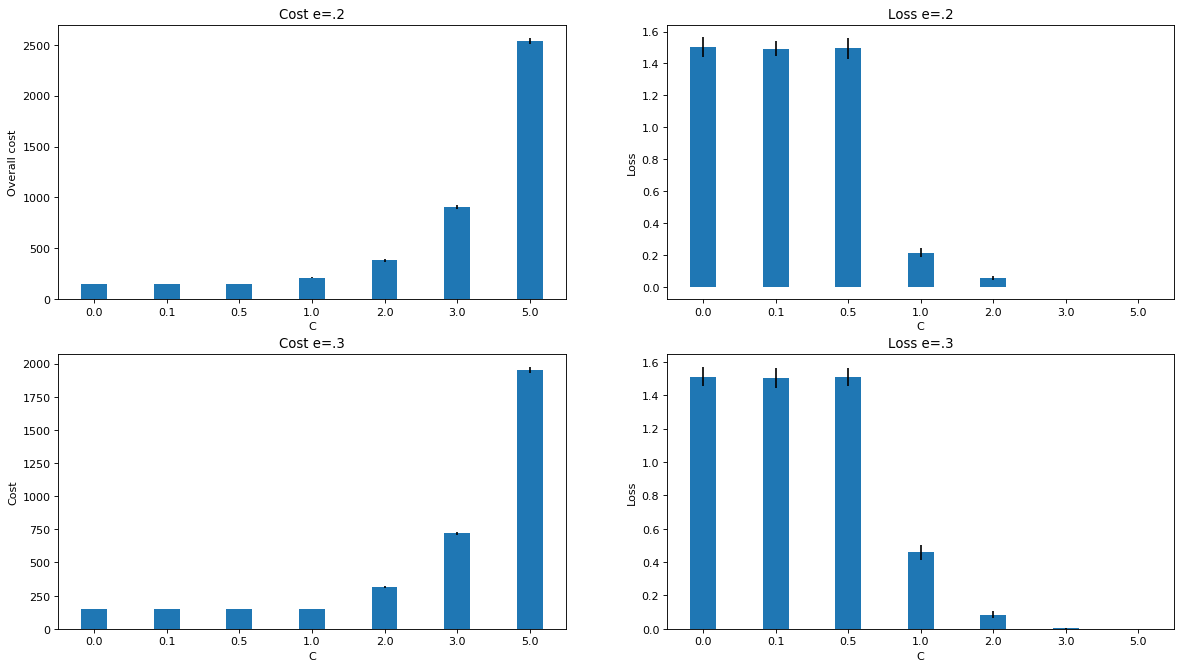

In [25]:
abraham_columns = ["c", "e"] + pdColumns
abraham_data = pd.read_csv('results/abraham/simulated/multiple_c_e_cts_b5/abraham_results.csv')
#abraham_data = pd.DataFrame(data, columns=abraham_columns)

abraham_e_02 = abraham_data[abraham_data['e'] == 0.2][abraham_data['Threshold'] == 0.5]
abraham_e_03 = abraham_data[abraham_data['e'] == 0.3][abraham_data['Threshold'] == 0.5]



plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
ind = [.14, .28, .42, .56, .70, .84, .98]    # the x locations for the groups
width = 0.05       # the width of the bars: can also be len(x) sequence

c_vals = abraham_e_02['c']

plt.subplot(221)
#cost_mean, cost_std = get_approaches_results(datasets, "Cost mean", "Cost Std")
p1 = plt.bar(ind, abraham_e_02['Cost mean'], width, yerr=abraham_e_02['Cost Std'])
plt.ylabel('Overall cost')
plt.xlabel('C')
plt.title('Cost e=.2')
plt.xticks(ind, c_vals)


plt.subplot(222)
#loss_mean, loss_std = get_approaches_results(datasets, "Loss mean", "Loss Std")
p2 = plt.bar(ind, abraham_e_02['Loss mean'], width, yerr=abraham_e_02['Loss Std'])
plt.ylabel('Loss')
plt.xlabel('C')
plt.title('Loss e=.2')
plt.xticks(ind, c_vals)

plt.subplot(223)
#cost_mean, cost_std = get_approaches_results(datasets, "Cost mean", "Cost Std")
p1 = plt.bar(ind, abraham_e_03['Cost mean'], width, yerr=abraham_e_03['Cost Std'])
plt.ylabel('Cost')
plt.xlabel('C')
plt.title('Cost e=.3')
plt.xticks(ind, c_vals)


plt.subplot(224)
#loss_mean, loss_std = get_approaches_results(datasets, "Loss mean", "Loss Std")
p2 = plt.bar(ind, abraham_e_03['Loss mean'], width, yerr=abraham_e_03['Loss Std'])
plt.ylabel('Loss')
plt.xlabel('C')
plt.title('Loss e=.3')
plt.xticks(ind, c_vals)

plt.show()

We can a observe that a higher $C$ increments quality and cost. For $e$ = .2 we can observe the best performance when $c$ = 1, and when $e$ = .3 the best $C$ is 2.

## Shortest Multi-Run

In [ ]:
from algorithms.sm_run.ShortestMultiRun.helpers.utils import Generator, Workers
from algorithms.sm_run.ShortestMultiRun.ShortestMultiRun import ShortestMultiRun

'''
z - proportion of cheaters
lr - loss ration, i.e., how much a False Negative is more harmful than a False Positive
votes_per_item - crowd votes per item for base round
worker_tests - number of test questions per worker
theta - overall proportion of positive items
filters_num - number of filters
filters_select - selectivity of filters (probability of applying a filter)
filters_dif - difficulty of filters
iter_num - number of iterations for averaging results
---------------------
FP == False Exclusion
FN == False Inclusion
'''



z = 0.3
items_per_worker = 10
baseround_items = 20  # must be a multiple of items_per_worker
if baseround_items % items_per_worker:
    raise ValueError('baseround_items must be a multiple of items_per_worker')
worker_tests = 5
votes_per_item = 3
lr = 5
theta = 0.3
iter_num = 50
data = []

#filters_num = 2
#items_num = 1000
#filters_select = [0.14, 0.14, 0.28, 0.42]
#filters_dif = [1., 1., 1.1, 0.9]

# S-run algorithm
loss_smrun_list = []
cost_smrun_list = []
rec_sm, pre_sm, f_sm, f_sm = [], [], [], []

filters_dif = []

#gt
# 1 = loneliness
for i in range(len(datasets)):
    
    filters_num = len(datasets[i]['predicates'])
    
    
    if (len(datasets[i]['predicates']) == 1):
        predicate_type = 'single'
        ground_truth = alg_utils.load_data(datasets, i, predicate_type)
        gt_p1 = ground_truth[datasets[i]['predicates'][0]]
        filters_select = [
            sum(gt_p1) / len(gt_p1)
        ]
    else:
        predicate_type = 'multi'
        ground_truth = alg_utils.load_data(datasets, i, predicate_type)
        gt_p1 = ground_truth[datasets[i]['predicates'][0]]
        gt_p2 = ground_truth[datasets[i]['predicates'][1]]
        filters_select = [
            sum(gt_p1) / len(gt_p1),
            sum(gt_p2) / len(gt_p2)
        ] 
    
    
    items_num = len(ground_truth[datasets[i]['predicates'][0]])

    params = {
        'filters_num': filters_num,
        'items_num': items_num,
        'baseround_items': baseround_items,
        'items_per_worker': items_per_worker,
        'votes_per_item': votes_per_item,
        'filters_select': filters_select,
        'filters_dif': filters_dif,
        'worker_tests': worker_tests,
        'lr': lr,
        'stop_score': 100
    }

    for _ in range(iter_num):
        # quiz, generation votes
        workers_accuracy = Workers(worker_tests, z).simulate_workers()
        params.update({'workers_accuracy': workers_accuracy,
                       'ground_truth': None
                       })

        _, ground_truth = Generator(params).generate_votes_gt(items_num)
        params.update({'ground_truth': ground_truth})

        # s-run
        loss_smrun, cost_smrun, rec_sm_, pre_sm_, f_beta_sm = ShortestMultiRun(params).run()
        loss_smrun_list.append(loss_smrun)
        cost_smrun_list.append(cost_smrun)
        rec_sm.append(rec_sm_)
        pre_sm.append(pre_sm_)
        f_sm.append(f_beta_sm)

    data.append([worker_tests, worker_tests, lr, np.mean(loss_smrun_list), np.std(loss_smrun_list),
                 np.mean(cost_smrun_list), np.std(cost_smrun_list), 'Crowd-Ensemble', np.mean(rec_sm),
                 np.std(rec_sm), np.mean(pre_sm), np.std(pre_sm), np.mean(f_sm), np.std(f_sm),
                 baseround_items, items_num, theta, filters_num])

    print('SM-RUN    loss: {:1.3f}, loss_std: {:1.3f}, recall: {:1.2f}, rec_std: {:1.3f}, '
          'price: {:1.2f}, price_std: {:1.2f}, precision: {:1.3f}, f_b: {}'
          .format(np.mean(loss_smrun_list), np.std(loss_smrun_list), np.mean(rec_sm),
                  np.std(rec_sm), np.mean(cost_smrun_list), np.std(cost_smrun_list),
                  np.mean(pre_sm), np.mean(f_sm)))

    dataset_name = datasets[i]['folder']
    pd.DataFrame(data,
                 columns=['worker_tests', 'worker_tests', 'lr', 'loss_mean', 'loss_std', 'price_mean', 'price_std',
                          'algorithm', 'recall', 'recall_std', 'precision', 'precision_std',
                          'f_beta', 'f_beta_std', 'baseround_items', 'total_items', 'theta', 'filters_num']
                 ).to_csv(f'results/sm_run/{dataset_name}_base.csv', index=False)

In [1]:
import numpy as np
import pandas as pd

from algorithms.sm_run.ShortestMultiRun.helpers.utils import Generator, Workers
from algorithms.sm_run.ShortestMultiRun.ShortestMultiRun import ShortestMultiRun

'''
z - proportion of cheaters
lr - loss ration, i.e., how much a False Negative is more harmful than a False Positive
votes_per_item - crowd votes per item for base round
worker_tests - number of test questions per worker
theta - overall proportion of positive items
filters_num - number of filters
filters_select - selectivity of filters (probability of applying a filter)
filters_dif - difficulty of filters
iter_num - number of iterations for averaging results
---------------------
FP == False Exclusion
FN == False Inclusion
'''

if __name__ == '__main__':
    z = 0.3
    items_num = 1000
    items_per_worker = 10
    baseround_items = 20  # must be a multiple of items_per_worker
    if baseround_items % items_per_worker:
        raise ValueError('baseround_items must be a multiple of items_per_worker')
    worker_tests = 5
    votes_per_item = 3
    lr = 5
    filters_num = 4
    theta = 0.3
    filters_select = [0.14, 0.14, 0.28, 0.42]
    filters_dif = [1., 1., 1.1, 0.9]
    iter_num = 50
    data = []
    
    params = {
        'filters_num': filters_num,
        'items_num': items_num,
        'baseround_items': baseround_items,
        'items_per_worker': items_per_worker,
        'votes_per_item': votes_per_item,
        'filters_select': filters_select,
        'filters_dif': filters_dif,
        'worker_tests': worker_tests,
        'lr': lr,
        'stop_score': 100
    }

    # S-run algorithm
    loss_smrun_list = []
    cost_smrun_list = []
    rec_sm, pre_sm, f_sm, f_sm = [], [], [], []
    for _ in range(iter_num):
        # quiz, generation votes
        workers_accuracy = Workers(worker_tests, z).simulate_workers()
        params.update({'workers_accuracy': workers_accuracy,
                       'ground_truth': None
                       })

        _, ground_truth = Generator(params).generate_votes_gt(items_num)
        params.update({'ground_truth': ground_truth})

        # s-run
        loss_smrun, cost_smrun, rec_sm_, pre_sm_, f_beta_sm = ShortestMultiRun(params).run()
        loss_smrun_list.append(loss_smrun)
        cost_smrun_list.append(cost_smrun)
        rec_sm.append(rec_sm_)
        pre_sm.append(pre_sm_)
        f_sm.append(f_beta_sm)

    data.append([worker_tests, worker_tests, lr, np.mean(loss_smrun_list), np.std(loss_smrun_list),
                 np.mean(cost_smrun_list), np.std(cost_smrun_list), 'Crowd-Ensemble', np.mean(rec_sm),
                 np.std(rec_sm), np.mean(pre_sm), np.std(pre_sm), np.mean(f_sm), np.std(f_sm),
                 baseround_items, items_num, theta, filters_num])

    print('SM-RUN    loss: {:1.3f}, loss_std: {:1.3f}, recall: {:1.2f}, rec_std: {:1.3f}, '
          'price: {:1.2f}, price_std: {:1.2f}, precision: {:1.3f}, f_b: {}'
          .format(np.mean(loss_smrun_list), np.std(loss_smrun_list), np.mean(rec_sm),
                  np.std(rec_sm), np.mean(cost_smrun_list), np.std(cost_smrun_list),
                  np.mean(pre_sm), np.mean(f_sm)))

    pd.DataFrame(data,
                 columns=['worker_tests', 'worker_tests', 'lr', 'loss_mean', 'loss_std', 'price_mean', 'price_std',
                          'algorithm', 'recall', 'recall_std', 'precision', 'precision_std',
                          'f_beta', 'f_beta_std', 'baseround_items', 'total_items', 'theta', 'filters_num']
                 ).to_csv('output_smv.csv', index=False)

SM-RUN    loss: 0.271, loss_std: 0.067, recall: 0.73, rec_std: 0.146, price: 11.35, price_std: 1.05, precision: 0.971, f_b: 0.7570017095420997


## Get Another Label? Sheng et al.

In [ ]:
import math
def gal_uncertainty(a, b, x = .5):
    result = 1
    a = a + 1
    b = b + 1
    for j in np.arange(1, a + b, 1):
        print(j)
        term_1 = math.factorial(a + b - 1) / (math.factorial(j) * math.factorial(a + b - 1 - j))
        term_2 = math.pow(x, j)
        term_3 = math.pow(1 - x, a + b - 1 - j)

        result *= term_1 * term_2 * term_3
        
    return result
    
gal_uncertainty(2, 1)

In [ ]:
from scipy.special import binom

pos_c = 1
neg_c = 3
n = 1
filter_acc = .7
filter_select = .8
term_neg = binom(pos_c + neg_c + n, neg_c + n) * filter_acc ** (neg_c + n) \
           * (1 - filter_acc) ** pos_c * filter_select
term_pos = binom(pos_c + neg_c + n, pos_c) * filter_acc ** pos_c \
           * (1 - filter_acc) ** (neg_c + n) * (1 - filter_select)
prob_item_neg = term_neg / (term_neg + term_pos)
print(prob_item_neg)





In [9]:
str([.5, .6, .7 , .8 , .9])

'[0.5, 0.6, 0.7, 0.8, 0.9]'